<a href="https://colab.research.google.com/github/roxyrong/w281-project/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 428 µs (started: 2023-12-11 10:55:55 +00:00)


In [ ]:
import os
import time
import copy
from glob import glob
import numpy as np
from numpy import fft
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report


time: 1.7 s (started: 2023-12-11 10:55:55 +00:00)


# Data Loading & Cleaning

In [ ]:
def load_dataset_parquet(datapath):
    df = pd.read_parquet(datapath)
    for idx, row in df.iterrows():
      df.at[idx, "image"] = df.at[idx, "image"].reshape((150, 150, 3)).astype("uint8")
    return df


train_path = "drive/MyDrive/github/w281-project-me/dataset/train_features_full.parquet.gzip"
test_path = "drive/MyDrive/github/w281-project-me/dataset/test_features_full.parquet.gzip"
train_df = load_dataset_parquet(train_path)
test_df = load_dataset_parquet(test_path)

time: 35.8 s (started: 2023-12-11 10:55:56 +00:00)


In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state = 314)

time: 7.17 ms (started: 2023-12-11 10:56:32 +00:00)


In [ ]:
print(train_df.groupby("category")["image"].count())
print(valid_df.groupby("category")["image"].count())
print(test_df.groupby("category")["image"].count())

category
buildings    1658
forest       1773
glacier      1871
mountain     1970
sea          1762
street       1653
Name: image, dtype: int64
category
buildings    435
forest       423
glacier      495
mountain     503
sea          425
street       391
Name: image, dtype: int64
category
buildings    414
forest       450
glacier      544
mountain     520
sea          481
street       444
Name: image, dtype: int64
time: 10 ms (started: 2023-12-11 10:56:32 +00:00)


# Modeling

In [ ]:
features_count = {"mean_h": 1,
                 "mean_s": 1,
                 "mean_v": 1,
                 "stddev_h": 1,
                 "stddev_s": 1,
                 "stddev_v": 1,
                 "pca_hsv_histogram" : 50,
                  "pca_hog_feature": 100,
                  "pca_vgg16_feature": 200,
                  "pca_fourier_feature": 25,
                  "pca_bag_of_visual_words": 40
                 }

features = list(features_count.keys())

time: 590 µs (started: 2023-12-11 10:56:32 +00:00)


In [ ]:
# Training set

X_train = np.hstack((train_df["mean_h"].to_numpy().reshape(-1, 1),
                     train_df["mean_s"].to_numpy().reshape(-1, 1),
                     train_df["mean_v"].to_numpy().reshape(-1, 1),
                     train_df["stddev_h"].to_numpy().reshape(-1, 1),
                     train_df["stddev_s"].to_numpy().reshape(-1, 1),
                     train_df["stddev_v"].to_numpy().reshape(-1, 1),
                     np.stack(train_df["pca_hsv_histogram"].to_numpy()),
                     np.stack(train_df["pca_hog_feature"].to_numpy()),
                     np.stack(train_df["pca_vgg16_feature"].to_numpy()),
                     np.stack(train_df["pca_fourier_feature"].to_numpy()),
                     np.stack(train_df["pca_bag_of_visual_words"].to_numpy())
                     ))
y_train = train_df["category"]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Valid Set
X_valid = np.hstack((valid_df["mean_h"].to_numpy().reshape(-1, 1),
                     valid_df["mean_s"].to_numpy().reshape(-1, 1),
                     valid_df["mean_v"].to_numpy().reshape(-1, 1),
                     valid_df["stddev_h"].to_numpy().reshape(-1, 1),
                     valid_df["stddev_s"].to_numpy().reshape(-1, 1),
                     valid_df["stddev_v"].to_numpy().reshape(-1, 1),
                     np.stack(valid_df["pca_hsv_histogram"].to_numpy()),
                     np.stack(valid_df["pca_hog_feature"].to_numpy()),
                     np.stack(valid_df["pca_vgg16_feature"].to_numpy()),
                     np.stack(valid_df["pca_fourier_feature"].to_numpy()),
                     np.stack(valid_df["pca_bag_of_visual_words"].to_numpy())
                     ))
X_valid = scaler.transform(X_valid)

y_valid = valid_df["category"]


# Test Set
X_test = np.hstack(( test_df["mean_h"].to_numpy().reshape(-1, 1),
                     test_df["mean_s"].to_numpy().reshape(-1, 1),
                     test_df["mean_v"].to_numpy().reshape(-1, 1),
                     test_df["stddev_h"].to_numpy().reshape(-1, 1),
                     test_df["stddev_s"].to_numpy().reshape(-1, 1),
                     test_df["stddev_v"].to_numpy().reshape(-1, 1),
                     np.stack(test_df["pca_hsv_histogram"].to_numpy()),
                     np.stack(test_df["pca_hog_feature"].to_numpy()),
                     np.stack(test_df["pca_vgg16_feature"].to_numpy()),
                     np.stack(test_df["pca_fourier_feature"].to_numpy()),
                     np.stack(test_df["pca_bag_of_visual_words"].to_numpy())
                     ))
X_test = scaler.transform(X_test)

y_test = test_df["category"]

time: 222 ms (started: 2023-12-11 10:56:32 +00:00)


In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 500]
}

lr = LogisticRegression(multi_class="multinomial",
                        solver="saga")

scoring = {"accuracy": make_scorer(accuracy_score),
           "precision": make_scorer(precision_score, average='macro'),
           "recall": make_scorer(recall_score, average='macro'),
           "f1": make_scorer(f1_score, average='macro')}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring=scoring, refit="f1")
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          solver='saga'),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2']},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, average=macro),
                      'precision': make_scorer(precision_score, average=macro),
                      'recall': make_scorer(recall_score, average=macro)})

time: 1h 42min 50s (started: 2023-12-11 10:56:32 +00:00)


In [ ]:
# fit_time
cv_results = grid_search.cv_results_

results_dict = {
    "params" : cv_results["params"],
    "mean_fit_time" : cv_results["mean_fit_time"],
    "mean_test_accuracy": cv_results["mean_test_accuracy"],
    "mean_test_precision": cv_results["mean_test_precision"],
    "mean_test_recall" : cv_results["mean_test_recall"],
    "mean_test_f1" : cv_results["mean_test_f1"],
}

cv_results_dict = pd.DataFrame.from_dict(results_dict)
print(cv_results_dict)

                                           params  mean_fit_time  \
0   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1'}      19.675980   
1   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}      14.802212   
2   {'C': 0.01, 'max_iter': 200, 'penalty': 'l1'}      39.056286   
3   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2'}      19.169459   
4   {'C': 0.01, 'max_iter': 500, 'penalty': 'l1'}      78.065249   
5   {'C': 0.01, 'max_iter': 500, 'penalty': 'l2'}      19.219309   
6    {'C': 0.1, 'max_iter': 100, 'penalty': 'l1'}      29.636551   
7    {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}      14.800061   
8    {'C': 0.1, 'max_iter': 200, 'penalty': 'l1'}      52.535624   
9    {'C': 0.1, 'max_iter': 200, 'penalty': 'l2'}      29.591324   
10   {'C': 0.1, 'max_iter': 500, 'penalty': 'l1'}     117.010624   
11   {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}      69.945194   
12     {'C': 1, 'max_iter': 100, 'penalty': 'l1'}      30.103067   
13     {'C': 1, 'max_iter': 100, 'penalty': 'l2'

              precision    recall  f1-score   support

   buildings       0.94      0.92      0.93       435
      forest       0.97      0.99      0.98       423
     glacier       0.87      0.87      0.87       495
    mountain       0.90      0.86      0.88       503
         sea       0.94      0.97      0.95       425
      street       0.93      0.94      0.93       391

    accuracy                           0.92      2672
   macro avg       0.92      0.93      0.92      2672
weighted avg       0.92      0.92      0.92      2672

accuracy: 0.9246098405746692


Text(0.5, 1.0, 'Confusion Matrix')

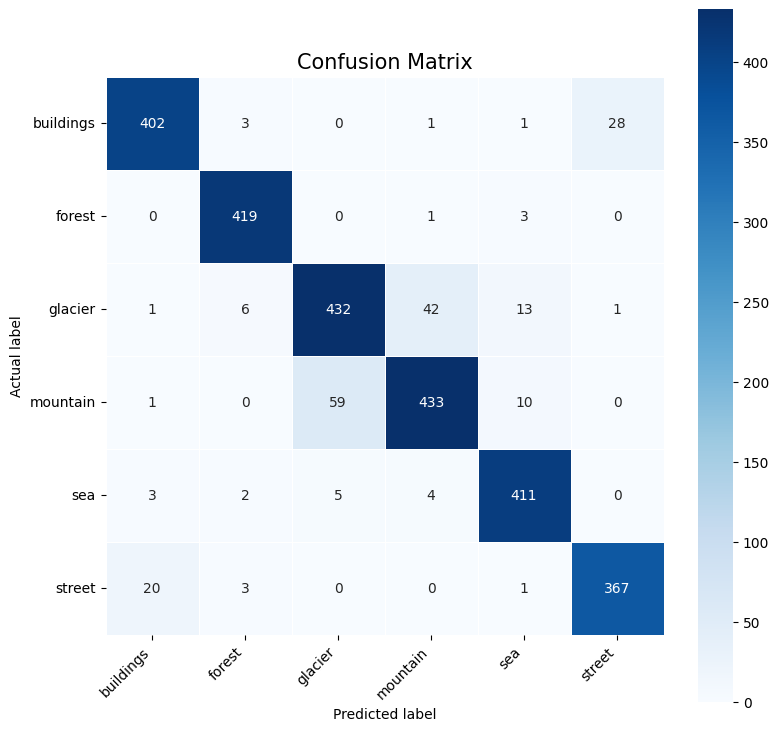

time: 643 ms (started: 2023-12-11 12:39:23 +00:00)


In [ ]:
# getting valid set result

y_valid_pred = grid_search.predict(X_valid)
valid_df['pred'] = y_valid_pred

print(classification_report(y_valid, y_valid_pred))

accuracy = grid_search.score(X_valid, y_valid)
print(f"accuracy: {accuracy}")

confusion_matrix = metrics.confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues");
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(6) + 0.5, labels=grid_search.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(6) + 0.5, labels=grid_search.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)

In [ ]:
coefficients = grid_search.best_estimator_.coef_

feature_names = list(features_count.keys())


feature_idx = 0
label_idx = 0
abs_coefficients = np.abs(coefficients)
num_features = coefficients.shape[1]

feature_importance_dict = {}

while feature_idx < num_features:
    feature_label = feature_names[label_idx]
    num_cols = features_count[feature_label]
    feature_importance_dict[feature_label] = np.mean(abs_coefficients[:,feature_idx: feature_idx + num_cols])
    feature_idx += num_cols
    label_idx += 1


# feature importance
sorted(feature_importance_dict.items(), key=lambda item: item[1])

[('stddev_s', 0.004840268934623322),
 ('pca_hog_feature', 0.016798572350174536),
 ('pca_hsv_histogram', 0.017352859181486383),
 ('pca_bag_of_visual_words', 0.028887555049348135),
 ('pca_vgg16_feature', 0.04169103666665585),
 ('mean_s', 0.042021891585922726),
 ('pca_fourier_feature', 0.04612970227299588),
 ('mean_h', 0.06543976619774976),
 ('stddev_h', 0.09960360957178666),
 ('stddev_v', 0.0997655242852986),
 ('mean_v', 0.10598733215594637)]

time: 4.57 ms (started: 2023-12-11 12:39:23 +00:00)


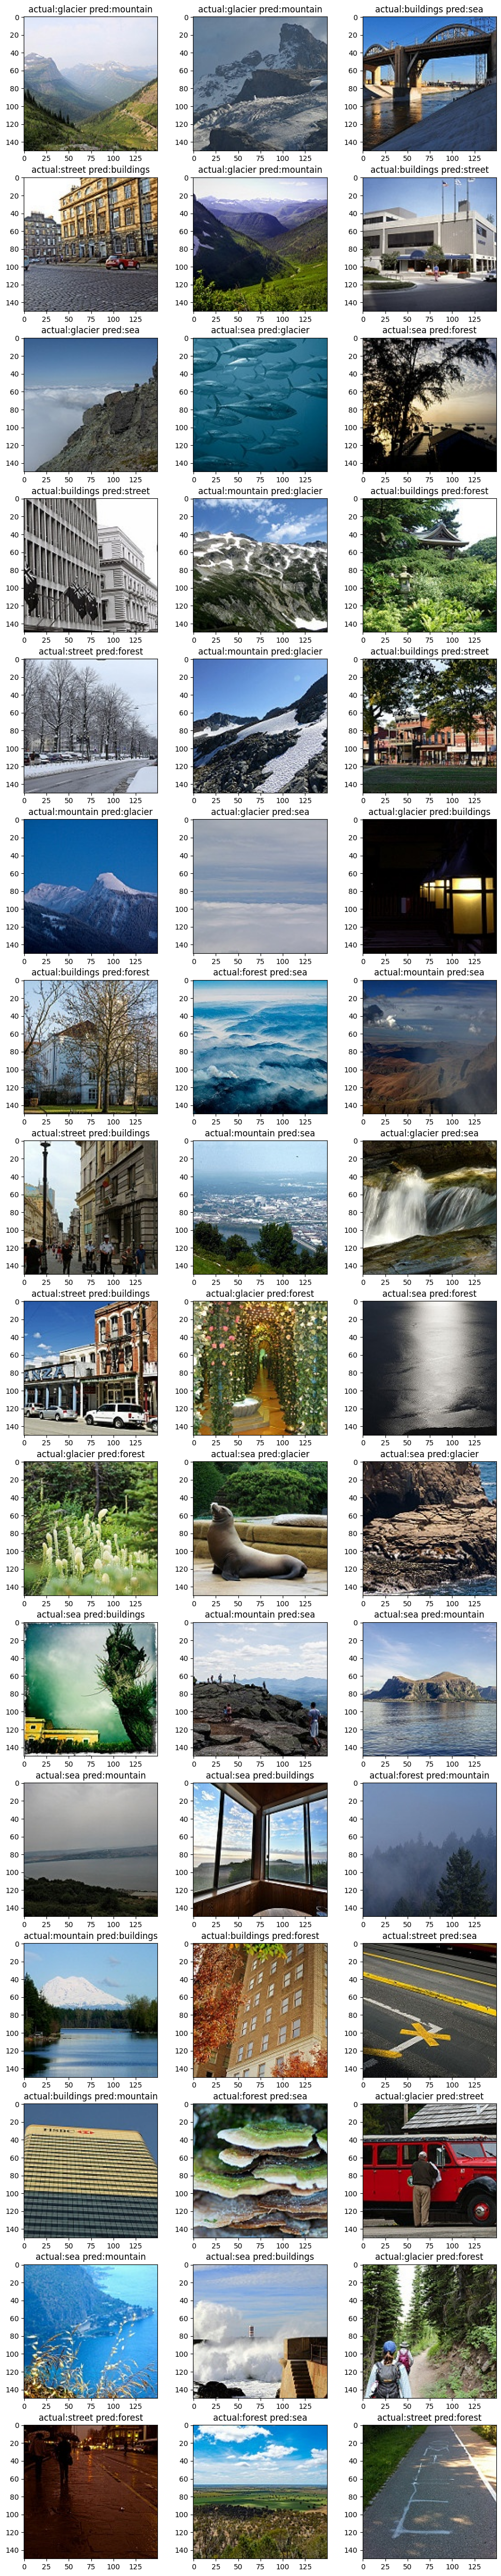

time: 12.5 s (started: 2023-12-11 14:24:59 +00:00)


In [ ]:
error_df = valid_df[valid_df["category"] != valid_df["pred"]]
error_df = error_df.groupby(["category", "pred"]).head(3).reset_index()

num_rows = len(error_df) // 3
if len(error_df) % 3 != 0:
    num_rows += 1

fig, axs = plt.subplots(num_rows, 3, figsize = (12, 4 * num_rows))

for idx, row in error_df.iterrows():
    img = Image.fromarray(row["image"])
    axs[idx // 3][idx % 3].imshow(img)
    axs[idx // 3][idx % 3].set_title(f"actual:{row['category']} pred:{row['pred']}")
